<a href="https://colab.research.google.com/github/namwootree/Basic_Skill/blob/main/Unsupervised%20Learning/%ED%95%B8%EC%A6%88%EC%98%A8%20%EB%B9%84%EC%A7%80%EB%8F%84%20%ED%95%99%EC%8A%B5/Ch_12_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN

* 생성자 : 입력 받은 실제 데이터의 샘플을 사용해 생성한 모델을 기반으로 데이터를 생성

* 감별자 : 생성자가 생성한 데이터와 실제 분포의 데이터 (실제 데이터)를 판별

* GAN은 레이블이 없는 경우에도 생성자가 실제 분포의 내재된 구조를 학습할 수 있으므로 비지도 학습 알고리즘에 속한다

* 생성자는 훈련된 데이터 양보다 훨씬 적은 수의 매개변수를 사용해 데이터의 내재된 구조를 학습

* 이 제약 조건으로, 생성자는 실제 데이터 분포의 가장 핵심적인 특징을 효율적으로 추출해야 한다

* 생성자의 신경망에 있는 각 은닉층은 데이터의 내재된 표현을 추출한다

* 그리고 후행 계층은 더 단순한 선행 계층 위에 구축함으로써 더 복잡한 표현을 추출한다

* 생성자는 이 모든 계층을 함께 사용해 데이터의 내재된 구조를 학습하고 실제 데이터와 거의 동일한 합성 데이터를 생성하려고 시도한다

* 생성자가 실제 데이터의 핵심을 성공적으로 추출했다면 합성 데이터는 실제 데이터처럼 보일 것

# Setting

## Library

In [1]:
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime

In [2]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import Grid
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

In [3]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
from keras.utils import to_categorical

In [4]:
import lightgbm as lgb

In [5]:
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import LeakyReLU, Reshape, UpSampling2D, Conv2DTranspose
from keras.layers import BatchNormalization, Input, Lambda
from keras.layers import Embedding, Flatten, dot
from keras import regularizers
from keras.losses import mse, binary_crossentropy
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.datasets import mnist

# Load Data Set

## Google Drive Mount

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Mnist Data Set

In [7]:
path_mnist = '/content/drive/MyDrive/머신러닝 엔지니어링/핸즈온 비지도 학습/data/mnist.pkl.gz'

f = gzip.open(path_mnist, 'rb')

train_set, val_set, test_set = pickle.load(f, encoding='latin1')
f.close()

In [8]:
X_train, y_train = train_set[0], train_set[1]
X_val, y_val = val_set[0], val_set[1]
X_test, y_test = test_set[0], test_set[1]

# Preprocesing

In [9]:
X_train_keras = X_train.reshape(50000,28,28,1)
X_validation_keras = X_val.reshape(10000,28,28,1)
X_test_keras = X_test.reshape(10000,28,28,1)

y_train_keras = to_categorical(y_train)
y_validation_keras = to_categorical(y_val)
y_test_keras = to_categorical(y_test)

In [10]:
train_index = range(0,len(X_train))
val_index = range(len(X_train), len(X_train)+len(X_val))
test_index = range(len(X_train)+len(X_val),
                   len(X_train)+len(X_val)+len(X_test))

X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)

X_validation = pd.DataFrame(data=X_val, index=val_index)
y_validation = pd.Series(data=y_val, index=val_index)

X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)

In [11]:
def view_digit(X, y, example):
    label = y.loc[example]
    image = X.loc[example,:].values.reshape([28,28])
    plt.title('Example: %d  Label: %d' % (example, label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

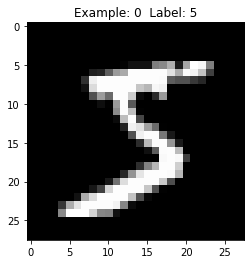

In [12]:
view_digit(X_train, y_train, 0)

# GPU 사용 확인

In [13]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else: print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


# CNN

## 모델 생성

In [14]:
model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size=(5,5),
                 padding='Same',
                 activation='relu',
                 input_shape=(28, 28, 1)))

model.add(Conv2D(filters = 32,
                 kernel_size=(5,5), 
                 padding='Same', 
                 activation='relu'))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 padding='Same', 
                 activation='relu'))

model.add(Conv2D(filters=64, 
                 kernel_size=(3,3), 
                 padding='Same', 
                 activation='relu'))

model.add(MaxPool2D(pool_size=(2,2),
                    strides=(2,2)))

model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation ="relu"))

model.add(Dropout(0.5))

model.add(Dense(10, activation = "softmax"))

## 모델 컴파일

In [15]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

## 모델 학습

In [16]:
cnn_history = model.fit(X_train_keras, y_train_keras, 
                        validation_data=(X_validation_keras,
                                         y_validation_keras),
                        epochs=100)

Epoch 1/100
1563/1563 [==============================] - 18s 6ms/step - loss: 0.1900 - accuracy: 0.9413 - val_loss: 0.0409 - val_accuracy: 0.9884
Epoch 2/100
1563/1563 [==============================] - 9s 5ms/step - loss: 0.0728 - accuracy: 0.9785 - val_loss: 0.0402 - val_accuracy: 0.9898
Epoch 3/100
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0546 - accuracy: 0.9838 - val_loss: 0.0295 - val_accuracy: 0.9917
Epoch 4/100
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0441 - accuracy: 0.9864 - val_loss: 0.0284 - val_accuracy: 0.9924
Epoch 5/100
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0383 - accuracy: 0.9884 - val_loss: 0.0322 - val_accuracy: 0.9920
Epoch 6/100
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0366 - accuracy: 0.9890 - val_loss: 0.0292 - val_accuracy: 0.9921
Epoch 7/100
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0332 - accuracy: 0.9905 - val_loss: 0.0276 - val_

## 학습 결과

In [16]:
print(cnn_history.history.keys())

CNN Final Val Accuracy 0.993399977684021


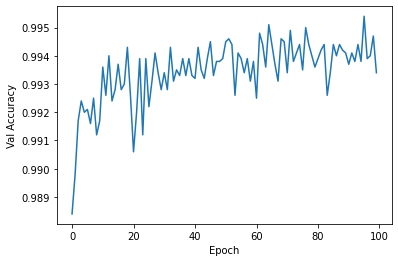

In [19]:
print("CNN Final Val Accuracy", cnn_history.history['val_accuracy'][-1])
pd.Series(cnn_history.history['val_accuracy']).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Val Accuracy")
plt.show()

# DCGAN

In [20]:
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time))

In [22]:
class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # 감별자
        self.G = None   # 생성자
        self.AM = None  # 적대 모델
        self.DM = None  # 판별 모델
        
    def generator(self, depth=256, dim=7, dropout=0.3, momentum=0.8, window=5, input_dim=100, output_depth=1):

        if self.G:
            return self.G

        self.G = Sequential()
        self.G.add(Dense(dim*dim*depth, input_dim=input_dim))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))
        
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), window, padding='same'))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))

        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), window, padding='same'))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(int(depth/8), window, padding='same'))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(output_depth, window, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()

        return self.G

    def discriminator(self, depth=64, dropout=0.3, alpha=0.3):

        if self.D:
            return self.D

        self.D = Sequential()

        input_shape = (self.img_rows, self.img_cols, self.channel)

        self.D.add(Conv2D(depth*1,
                          5,
                          strides=2,
                          input_shape=input_shape,
                          padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2,
                          5,
                          strides=2,
                          padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4,
                          5,
                          strides=2,
                          padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8,
                          5,
                          strides=1,
                          padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()

        return self.D

    def discriminator_model(self):

        if self.DM:
            return self.DM

        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', 
                        optimizer=optimizer,
                        metrics=['accuracy'])
        
        return self.DM

    def adversarial_model(self):

        if self.AM:
            return self.AM

        optimizer = RMSprop(lr=0.0001, decay=3e-8)

        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
        
        return self.AM

## DCGAN 초기화 및 훈련

In [28]:
class MNIST_DCGAN(object):
    def __init__(self, x_train):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1

        self.x_train = x_train

        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()

    def train(self, train_steps=2000, batch_size=256, save_interval=0):

        noise_input = None

        if save_interval>0:

            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])

        for i in range(train_steps):

            images_train = self.x_train[np.random.randint(0,
                                                          self.x_train.shape[0],
                                                          size=batch_size),
                                         :, :, :]
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            
            d_loss = self.discriminator.train_on_batch(x, y)

            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True,
                                     samples=noise_input.shape[0],
                                     noise=noise_input, step=(i+1))

    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        current_path = os.getcwd()
        file = os.path.sep.join(['', 'images', ''])
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(current_path+file+filename)
            plt.close('all')
        else:
            plt.show()

In [29]:
!mkdir images

mkdir: cannot create directory ‘images/chapter12/synthetic_mnist’: No such file or directory


In [30]:
mnist_dcgan = MNIST_DCGAN(X_train_keras)
timer = ElapsedTimer()
mnist_dcgan.train(train_steps=1000, batch_size=256, save_interval=500)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_9 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 4, 4, 256)        

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 12544)             1266944   
                                                                 
 batch_normalization_4 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 dropout_12 (Dropout)        (None, 7, 7, 256)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 256)      0         
 2D)                                                  

## 합성 MNIST 이미지 배치 생성

Elapsed: 4.846509742736816 min 
1/1 [==============================] - 0s 20ms/step


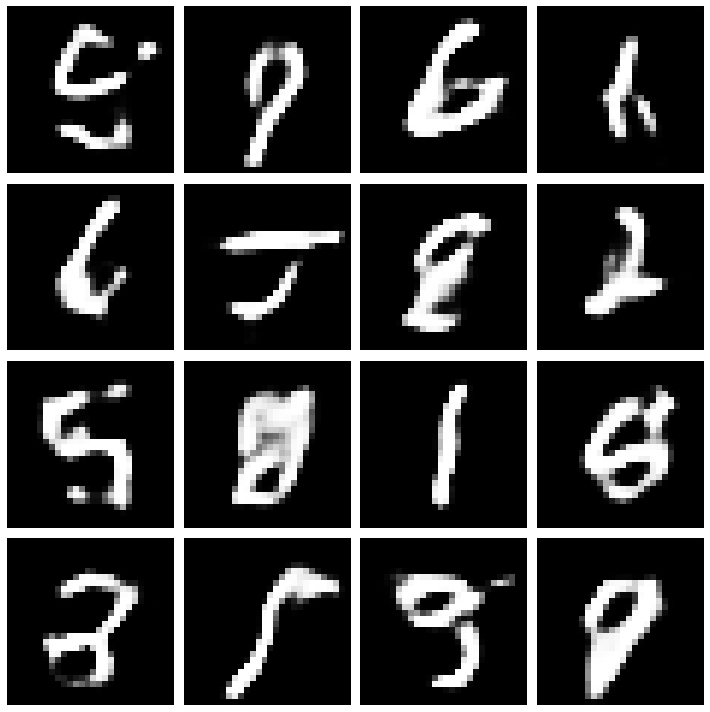

In [31]:
timer.elapsed_time()
mnist_dcgan.plot_images(fake=True)
mnist_dcgan.plot_images(fake=False, save2file=True)